## _Inference after GNN Stage_

**_Inference_** is done using callbacks defined in the **_LightningModules/GNN/Models/inference.py_**. The callbacks run during the **_test_step()_** _a.k.a_ model _**evalution**_.

### How to run _Inference_?

1. _`traintrack config/pipeline_quickstart.yaml`_. One can use `--inference` flag to run only the test_step() (Should work, but failed.)
2. _`infer.ipynb`_ notebook runs the _pl.Trainer().test()_

In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
from tqdm import tqdm
import trackml.dataset

In [4]:
import torch
import pytorch_lightning as pl
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
os.environ['EXATRKX_DATA'] = os.path.abspath(os.curdir)

In [7]:
from LightningModules.GNN import InteractionGNN
from LightningModules.GNN import GNNMetrics

In [8]:
from LightningModules.GNN.Models.infer import GNNTelemetry

## _Classifier Evaluation_

Metrics to evaluate the GNN networks:

- Accuracy/ACC = $TP+TN/TP+TN+FP+FN$
- sensitivity, recall, hit rate, or true positive rate ($TPR = 1 - FNR$)
- specificity, selectivity or true negative rate ($TNR = 1 - FPR$)
- miss rate or false negative rate ($FNR = 1 - TPR$)
- fall-out or false positive rate ($FPR = 1 - TNR$)
- F1-score = $2 \times (\text{PPV} \times \text{TPR})/(\text{PPV} + \text{TPR})$
- Efficiency/Recall/Sensitivity/Hit Rate: $TPR = TP/(TP+FN)$
- Purity/Precision/Positive Predictive Value: $PPV = TP/(TP+FP$
- AUC-ROC Curve $\equiv$ FPR ($x-$axis) v.s. TPR ($y-$axis) plot
- AUC-PRC Curve $\equiv$ TPR ($x-$axis) v.s. PPV ($y-$axis) plot

### _(+) - Test Dataset_

In [9]:
# Test Dataset from GNNBuilder
inputdir="run/gnn_evaluation/test"
all_events = sorted(glob.glob(os.path.join(inputdir, "*")))

In [10]:
# Load Single Event
test_event = torch.load(all_events[0], map_location=device)

### _(+) - Load Model_

- Load model checkpoint
- Load saved config file

In [11]:
# Path of Model Checkpoint
ckpnt_path = "run/lightning_models/lightning_checkpoints/GNNStudy/version_1/checkpoints/last.ckpt"

In [12]:
# Load Model Checkpoint
checkpoint = torch.load(ckpnt_path, map_location=device)

In [13]:
# View Hyperparameters
print(checkpoint["hyper_parameters"])

{'input_dir': '/global/cscratch1/sd/aakram/run/feature_store', 'output_dir': '/global/cscratch1/sd/aakram/run/gnn_evaluation', 'project': 'GNNStudy', 'edge_cut': 0.5, 'pt_signal_min': 0.0, 'pt_background_min': 0.0, 'datatype_names': ['train', 'val', 'test'], 'datatype_split': [90000, 5000, 5000], 'noise': False, 'overwrite': True, 'spatial_channels': 3, 'cell_channels': 0, 'hidden': 128, 'n_graph_iters': 8, 'nb_node_layer': 3, 'nb_edge_layer': 3, 'emb_channels': 0, 'layernorm': True, 'aggregation': 'sum_max', 'hidden_activation': 'ReLU', 'weight': 2, 'warmup': 200, 'lr': 0.001, 'factor': 0.3, 'patience': 10, 'regime': 'pid', 'max_epochs': 40, 'callbacks': ['GNNTelemetry', 'GNNBuilder'], 'resume_id': 'version_1', 'logger': 'tb', 'model_library': 'LightningModules', 'artifact_library': '/global/cscratch1/sd/aakram/run/lightning_models/lightning_checkpoints', 'set': 'GNN', 'name': 'InteractionGNN', 'config': 'train_quickstart_GNN.yaml', 'batch_config': 'batch_gpu_default.yaml', 'inference

In [14]:
# Get Hyperparameters as a Variable
config = checkpoint["hyper_parameters"]

In [15]:
# One Can Modify Hyperparameters
config["checkpoint_path"] = ckpnt_path
config["input_dir"] = "run/feature_store"
config["output_dir"] = "run/gnn_evaluation"
config["artifact_library"] = "lightning_models/lightning_checkpoints"
config["datatype_split"] = [0, 0, 5000]
config["map_location"] = device

In [16]:
# View Hyperparameters (Modified)
print(checkpoint["hyper_parameters"])

{'input_dir': 'run/feature_store', 'output_dir': 'run/gnn_evaluation', 'project': 'GNNStudy', 'edge_cut': 0.5, 'pt_signal_min': 0.0, 'pt_background_min': 0.0, 'datatype_names': ['train', 'val', 'test'], 'datatype_split': [0, 0, 5000], 'noise': False, 'overwrite': True, 'spatial_channels': 3, 'cell_channels': 0, 'hidden': 128, 'n_graph_iters': 8, 'nb_node_layer': 3, 'nb_edge_layer': 3, 'emb_channels': 0, 'layernorm': True, 'aggregation': 'sum_max', 'hidden_activation': 'ReLU', 'weight': 2, 'warmup': 200, 'lr': 0.001, 'factor': 0.3, 'patience': 10, 'regime': 'pid', 'max_epochs': 40, 'callbacks': ['GNNTelemetry', 'GNNBuilder'], 'resume_id': 'version_1', 'logger': 'tb', 'model_library': 'LightningModules', 'artifact_library': 'lightning_models/lightning_checkpoints', 'set': 'GNN', 'name': 'InteractionGNN', 'config': 'train_quickstart_GNN.yaml', 'batch_config': 'batch_gpu_default.yaml', 'inference': False, 'checkpoint_path': 'run/lightning_models/lightning_checkpoints/GNNStudy/version_1/che

In [17]:
# Init the InteractionGNN
model = InteractionGNN(config)

In [18]:
# Provide Modified Hyperparameters
model = model.load_from_checkpoint(**config)

In [19]:
# Load Trainer
trainer = pl.Trainer(callbacks=[GNNTelemetry()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Testing:   0%|                                                                                    | 1/5000 [00:00<26:44,  3.11it/s]

/shared/adeel/anaconda/envs/exatrkx-cpu/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Testing: 100%|████████████████████████████████████████████████████████████████████████████████▉| 4999/5000 [05:21<00:00, 15.27it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
preds: torch.Size([7836002]), truth: torch.Size([7836002])
Testing: 100%|█████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:23<00:00, 15.45it/s]


[{}]

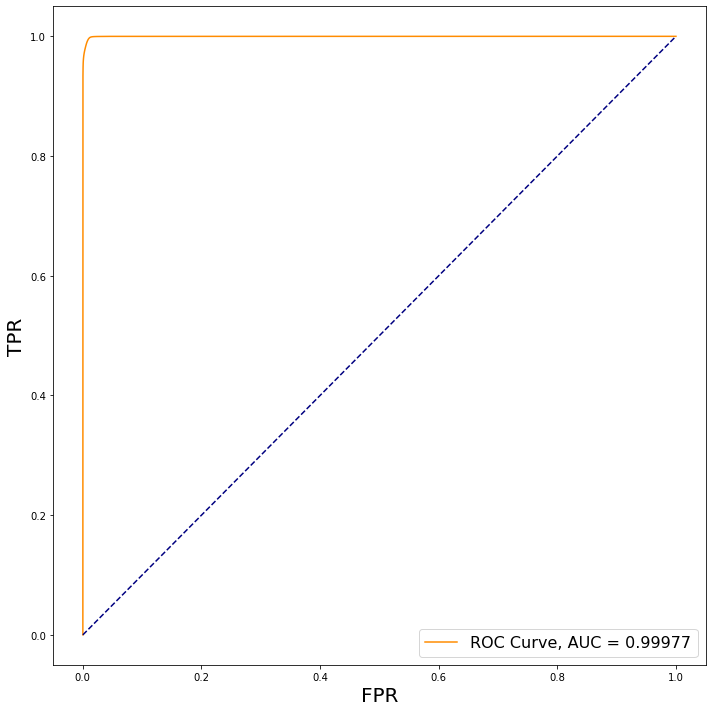

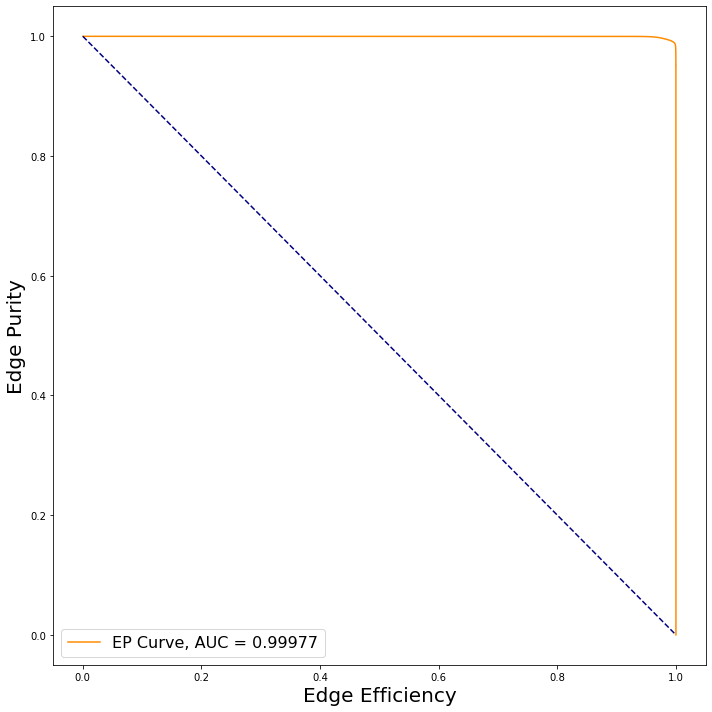

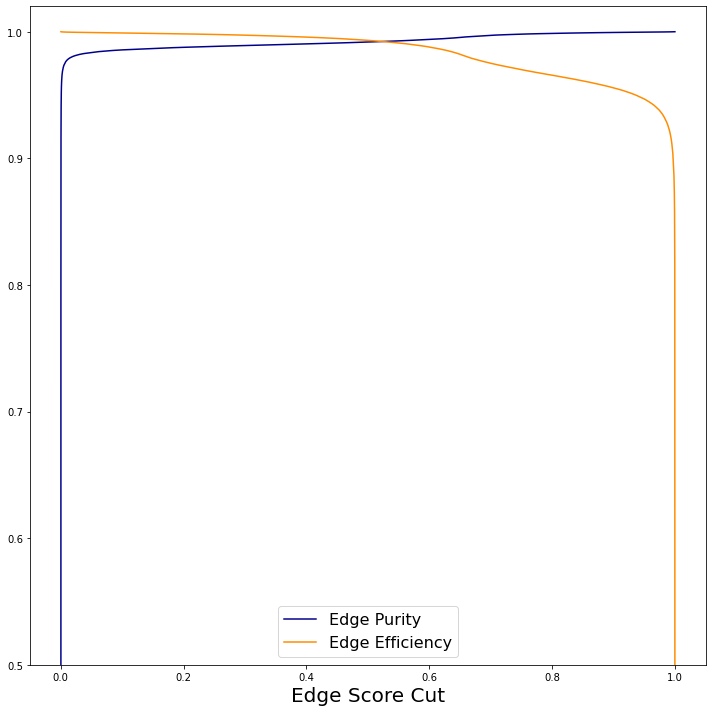

In [20]:
# Test Loop
trainer.test(model=model, verbose=True)